In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)
!pip install rouge
!pip install wandb

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.25.1
Using datasets v2.8.0
Using accelerate v0.15.0
Using sentencepiece v0.1.97
Using sacrebleu v2.3.1
Using rouge_score
Using nltk v3.7
Using py7zr v0.20.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 24.1 MB/s eta 0:00:00
  Preparin

In [2]:
import datasets
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
import re
import torch
from rouge import Rouge
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback

)
from datasets import Dataset
from tqdm import tqdm
import glob
import json
import os

In [3]:
def load_json_data(path):

    with open(path) as f:
        data = json.load(f)

    ids = []
    dialogues = []
    summaries = []
    topic = []
    for datum in data["data"]:
        ids.append(datum["header"]["dialogueInfo"]["dialogueID"])

        prev_speaker_id = None
        prev_line = ""
        utts = []
        for dialogue in datum["body"]["dialogue"]:
            utterance = dialogue["utterance"].strip()

            if dialogue["participantID"] == prev_speaker_id:
                prev_line += " " + utterance
            else:
                if prev_line:
                    utts.append(prev_line)
                prev_line = utterance
                prev_speaker_id = dialogue["participantID"]
        if prev_line:
            utts.append(prev_line)

        dialogues.append(utts)
        summaries.append(datum["body"].get("summary"))

    for i in range(len(data['data'])):
      topic.append(data['data'][i]['header']['dialogueInfo']['topic'])
    return ids, dialogues, summaries, topic

def data_load(filename, is_meta=False):
    ids_list, dialogues_list, summaries_list, topic_list = [], [], [], []
    dialogues_sep = []

    for file in tqdm(filename):
      ids, dialogues, summaries, topic = load_json_data(file)
      for id, text, summ, top in zip(ids, dialogues, summaries, topic):
        ids_list.append(id)
        if is_meta:
          text.insert(0,"#"+top+"#")
        dialogues_list.append(text)
        summaries_list.append(summ)
        topic_list.append(top)
    
    for text in tqdm(dialogues_list):
      dialogues_sep.append("[sep]".join(text))

    return ids_list, dialogues_sep, summaries_list


In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+[/ㄱ-ㅎㅏ-ㅣ]', '', sentence) # 여러개 자음과 모음을 삭제한다.
    sentence = re.sub("[^가-힣a-z0-9#@,-\[\]\(\)]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개 공백을 하나의 공백으로 바꿉니다.
    sentence = sentence.strip() # 문장 양쪽 공백 제거
    
    return sentence

def data_process(data):
  # 전체 Text 데이터에 대한 전처리 (1)
  text = []

  for data_text in tqdm(data):
    text.append(preprocess_sentence(data_text))
  
  return text

In [5]:
dirname = "/content/drive/MyDrive/인공지능/아이펠톤/PoC/kt_data/Training"
filenames = os.listdir(dirname) 
train_full_filename = []

for filename in filenames:
    fn = os.path.join(dirname, filename)
    if dirname + '/.ipynb_checkpoints' != fn:
        train_full_filename.append(fn)

dirname2 = "/content/drive/MyDrive/인공지능/아이펠톤/PoC/kt_data/Validation"
filenames2 = os.listdir(dirname2) 
val_full_filename = []

for filename in filenames2:
    fn2 = os.path.join(dirname2, filename)
    if dirname + '/.ipynb_checkpoints' != fn2:
        val_full_filename.append(fn2)

In [6]:
train_ids, train_dialogues, train_summaries = data_load(train_full_filename, is_meta=True)
val_ids, val_dialogues, val_summaries = data_load(val_full_filename)

train_texts = data_process(train_dialogues)
val_texts = data_process(val_dialogues)

train_df = pd.DataFrame(zip(train_texts,train_summaries), columns=['Text', 'Summary'])
val_df = pd.DataFrame(zip(val_texts,val_summaries), columns=['Text', 'Summary'])

100%|██████████| 35004/35004 [00:00<00:00, 47948.13it/s]


In [7]:
train_df.head()

,Text,Summary
0,#상거래(쇼핑)#[sep]그럼 날짜는 가격 큰 변동 없으면 6.28-7.13로 확정...,"비행기 표 가격에 대해 이야기하며, 특가 이벤트를 기다리고 있다."
1,#상거래(쇼핑)#[sep]kf마스크만 5부제 하는거지?[sep]응. 면마스크는 아무...,비염이 있어서 싸게 나온 일회용 부직포 마스크를 사두려고 한다.
2,#상거래(쇼핑)#[sep]아 근데 케이크 업체들 봤는데 중앙동쪽 거기는 맛만있고 디...,케이크 업체 중 중앙동 쪽은 맛만 있고 디자인은 별로고 고잔동 케이크 업체는 배달도...
3,#상거래(쇼핑)#[sep]칫솔사야하는데 쓱으로 살까?[sep]뭘 칫솔사는것까지 물어...,칫솔을 3개월에 하나씩 바꿔서 왕 칫솔 사러 신세계(쓱) 가자고 했다.
4,#상거래(쇼핑)#[sep]잠도안오네 얼릉 고구마츄 먹고싶단[sep]그게 그렇게 맛있...,잠도 안 와서 고구마 말랭이를 양심상 하나만 먹으려고 한다.


In [8]:
# DF > data Set으로 전환
train_data = Dataset.from_pandas(train_df) 
val_data = Dataset.from_pandas(val_df)
test_samples = Dataset.from_pandas(val_df)

print(train_data)
print(val_data)
print(test_samples)

Dataset({
    features: ['Text', 'Summary'],
    num_rows: 279992
})
Dataset({
    features: ['Text', 'Summary'],
    num_rows: 35004
})
Dataset({
    features: ['Text', 'Summary'],
    num_rows: 35004
})


In [9]:
model_checkpoints = "gogamza/kobart-base-v2"


tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)

special_words = [
                "#@주소#", "#@이모티콘#", "#@이름#", "#@URL#", "#@소속#",
                "#@기타#", "#@전번#", "#@계정#", "#@url#", "#@번호#", "#@금융#", "#@신원#",
                "#@장소#", "#@시스템#사진#", "#@시스템#동영상#", "#@시스템#기타#", "#@시스템#검색#",
                "#@시스템#지도#", "#@시스템#삭제#", "#@시스템#파일#", "#@시스템#송금#", "#@시스템#",
                "#개인 및 관계#", "#미용과 건강#", "#상거래(쇼핑)#", "#시사/교육#", "#식음료#", 
                "#여가 생활#", "#일과 직업#", "#주거와 생활#", "#행사#","[sep]"
                ]

tokenizer.add_special_tokens({"additional_special_tokens": special_words})
model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/682k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

Embedding(30032, 768)

100%|██████████| 279992/279992 [00:22<00:00, 12588.10it/s]


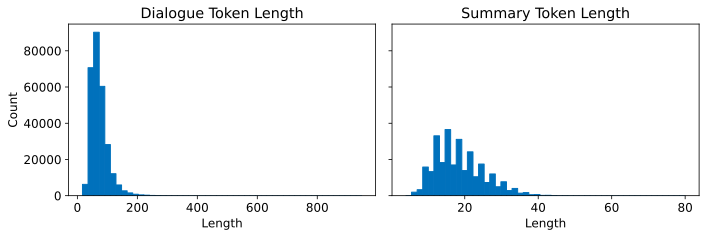

In [10]:
t_len = [len(tokenizer.encode(s)) for s in tqdm(train_df['Text'])]
s_len = [len(tokenizer.encode(s)) for s in tqdm(train_df['Summary'])]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(t_len, bins=50, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=50, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [11]:
max_input = 256
max_target = 64
ignore_index = -100# tokenizer.pad_token_id

def add_ignored_data(inputs, max_len, ignore_index):
  if len(inputs) < max_len:
      pad = [ignore_index] *(max_len - len(inputs)) # ignore_index즉 -100으로 패딩을 만들 것인데 max_len - lne(inpu)
      inputs = np.concatenate([inputs, pad])
  else:
      inputs = inputs[:max_len]

  return inputs

def add_padding_data(inputs, max_len):
    pad_index = tokenizer.pad_token_id
    if len(inputs) < max_len:
        pad = [pad_index] *(max_len - len(inputs))
        inputs = np.concatenate([inputs, pad])
    else:
        inputs = inputs[:max_len]

    return inputs 

def preprocess_data(data_to_process):
    label_id= []
    label_ids = []
    dec_input_ids = []
    input_ids = []
    bos = tokenizer('<s>')['input_ids']
    for i in range(len(data_to_process['Text'])):
        input_ids.append(add_padding_data(tokenizer.encode(data_to_process['Text'][i], add_special_tokens=False), max_input))
    for i in range(len(data_to_process['Summary'])):
        label_id.append(tokenizer.encode(data_to_process['Summary'][i]))  
        label_id[i].append(tokenizer.eos_token_id)   
        dec_input_id = bos
        dec_input_id += label_id[i][:-1]
        dec_input_ids.append(add_padding_data(dec_input_id, max_target))  
    for i in range(len(data_to_process['Summary'])):
        label_ids.append(add_ignored_data(label_id[i], max_target, ignore_index))
   
    return {'input_ids': input_ids,
            'attention_mask' : (np.array(input_ids) != tokenizer.pad_token_id).astype(int),
            'decoder_input_ids': dec_input_ids,
            'decoder_attention_mask': (np.array(dec_input_ids) != tokenizer.pad_token_id).astype(int),
            'labels': label_ids}

train_tokenize_data = train_data.map(preprocess_data, batched = True, remove_columns=['Text', 'Summary'])
val_tokenize_data = val_data.map(preprocess_data, batched = True, remove_columns=['Text', 'Summary'])

  0%|          | 0/280 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

In [12]:
rouge = Rouge()
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    
    return rouge.get_scores(pred_str, label_str, avg=True)   

In [15]:
model.config.max_length = 64 
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 5

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/인공지능/생성요약프로젝트/Model/KoBART/checkpoint/KoBART_Summary_v2",
    num_train_epochs=4,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=128,  # demo
    per_device_eval_batch_size=256,
    learning_rate=3e-05,
    weight_decay=0.1,
    #label_smoothing_factor=0.1,
    predict_with_generate=True, # 생성기능을 사용하고 싶다고 지정한다.
    logging_dir="/content/drive/MyDrive/인공지능/생성요약프로젝트/Model/KoBART/logs2",
    save_total_limit=3,
    load_best_model_at_end = True,
    logging_strategy = 'epoch',
    evaluation_strategy  = 'epoch',
    save_strategy ='epoch',
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model) # 데이터 일괄 처리?

trainer = Seq2SeqTrainer(
    model, 
    training_args,
    train_dataset=train_tokenize_data,
    eval_dataset=val_tokenize_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 279992
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 8752
  Number of trainable parameters = 123884544
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,2.103400,1.936243,"{'r': 0.2532425738479467, 'p': 0.2551666265277008, 'f': 0.24550081661885623}","{'r': 0.09979969750726092, 'p': 0.10193768112782223, 'f': 0.09679460789876963}","{'r': 0.24009666761548037, 'p': 0.24185785000686832, 'f': 0.2327152779955089}"
2,1.877300,1.870924,"{'r': 0.2589696995530573, 'p': 0.26202642687810374, 'f': 0.25169722617344864}","{'r': 0.10531414920889294, 'p': 0.1082094047801753, 'f': 0.10253707643574328}","{'r': 0.2457109855272182, 'p': 0.24845583731936938, 'f': 0.23871221923233688}"


***** Running Evaluation *****
  Num examples = 35004
  Batch size = 256
Trainer is attempting to log a value of "{'r': 0.2532425738479467, 'p': 0.2551666265277008, 'f': 0.24550081661885623}" of type <class 'dict'> for key "eval/rouge-1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'r': 0.09979969750726092, 'p': 0.10193768112782223, 'f': 0.09679460789876963}" of type <class 'dict'> for key "eval/rouge-2" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'r': 0.24009666761548037, 'p': 0.24185785000686832, 'f': 0.2327152779955089}" of type <class 'dict'> for key "eval/rouge-l" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to /content/drive/MyDrive/인공지능/생성요약프로젝트/Model/KoBART/checkp

Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,2.103400,1.936243,"{'r': 0.2532425738479467, 'p': 0.2551666265277008, 'f': 0.24550081661885623}","{'r': 0.09979969750726092, 'p': 0.10193768112782223, 'f': 0.09679460789876963}","{'r': 0.24009666761548037, 'p': 0.24185785000686832, 'f': 0.2327152779955089}"
2,1.877300,1.870924,"{'r': 0.2589696995530573, 'p': 0.26202642687810374, 'f': 0.25169722617344864}","{'r': 0.10531414920889294, 'p': 0.1082094047801753, 'f': 0.10253707643574328}","{'r': 0.2457109855272182, 'p': 0.24845583731936938, 'f': 0.23871221923233688}"
3,1.765300,1.848333,"{'r': 0.2639644666215957, 'p': 0.2634907867303786, 'f': 0.2548666400008486}","{'r': 0.10715553904529614, 'p': 0.10829148856567945, 'f': 0.10348113538698803}","{'r': 0.2503715715530152, 'p': 0.24975972274020622, 'f': 0.24164820586821611}"


***** Running Evaluation *****
  Num examples = 35004
  Batch size = 256
Trainer is attempting to log a value of "{'r': 0.2639644666215957, 'p': 0.2634907867303786, 'f': 0.2548666400008486}" of type <class 'dict'> for key "eval/rouge-1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'r': 0.10715553904529614, 'p': 0.10829148856567945, 'f': 0.10348113538698803}" of type <class 'dict'> for key "eval/rouge-2" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'r': 0.2503715715530152, 'p': 0.24975972274020622, 'f': 0.24164820586821611}" of type <class 'dict'> for key "eval/rouge-l" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to /content/drive/MyDrive/인공지능/생성요약프로젝트/Model/KoBART/checkpo

KeyboardInterrupt: ignored

In [ ]:
def generate_summary(test_samples, model):

    inputs = tokenizer(
        test_samples["Text"],
        padding="max_length",
        truncation=True,
        max_length=max_target,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)

    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, num_beams=5, no_repeat_ngram_size=3,
                            attention_mask=attention_mask, 
                            pad_token_id=tokenizer.pad_token_id,
                            bos_token_id=tokenizer.bos_token_id,
                            eos_token_id=tokenizer.eos_token_id,)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str

summaries_after_tuning=[]
for test_sample in tqdm(test_samples):
    summaries_after_tuning.append(generate_summary(test_sample, model)[1])
summaries_after_tuning = list(itertools.chain(*summaries_after_tuning))

In [ ]:
rouge.get_scores(summaries_after_tuning, test_samples["Summary"], avg=True)

In [ ]:
for i in range(0, len(summaries_after_tuning), 1000):
    print('idx_{} '.format(i))
    print("Summary after \n"+ summaries_after_tuning[i])
    print("")
    print("Target summary \n"+ test_samples["Summary"][i])
    print("")
    print('Text'+ test_samples["Text"][i])
    print('-'*100)
    print("") 